In [1]:
# To install the packages you'll need, try:
# Pkg.clone("https://github.com/rdeits/DrakeVisualizer.jl.git")
# Pkg.clone("https://github.com/rdeits/SpatialFields.jl")
# Pkg.clone("https://github.com/rdeits/LCMGL.jl")
# Pkg.build("LCMGL")
# Pkg.add("Interact")
# Pkg.add("Images")

using DrakeVisualizer
using SpatialFields
using LCMGL
using Interact
using GeometryTypes
using Images
using AffineTransforms

In [2]:
data = readdlm("box_on_table_points.txt", ',')
surface_points = Point{3, Float64}[vec(data[i,:]) for i in 2:size(data, 1)]

camera = Point{3, Float64}(vec(data[1,:]))
interior_points = [camera]

for i = 1:length(surface_points)
    p = surface_points[i]
    ray_to_camera = camera - p
    ray_to_camera /= norm(ray_to_camera)
    
    push!(interior_points, p + 0.02 * ray_to_camera)
end

In [3]:
vis = Visualizer()
points = vcat(surface_points, interior_points)
values = vcat([0. for p in surface_points], [1.], [0.02 for p in 2:length(interior_points)])
field = InterpolatingSurface(points, values, SpatialFields.XCubed())
window = HyperRectangle(Vec(minimum(surface_points)), Vec(maximum(surface_points) - minimum(surface_points)))

LCMGLClient("points") do lcmgl
    for i = 1:length(points)
        if values[i] == 0
            color(lcmgl, 0, 0, 0)
        else
            color(lcmgl, 0, 0, 1)
        end
        sphere(lcmgl, convert(Vector, points[i]), 0.005, 10, 10)
    end
    switch_buffer(lcmgl)
end

In [4]:
gradient = grad(field)

LCMGLClient("normals") do lcmgl
    color(lcmgl, 0, 0, 0)
    begin_mode(lcmgl, LCMGL.LINES)
    for i = 1:length(surface_points)
        p = surface_points[i]
        g = evaluate(gradient, p)
        u = p - 0.05 * Point(g / norm(g))
        vertex(lcmgl, p[1], p[2], p[3])
        vertex(lcmgl, u[1], u[2], u[3])
    end
    end_mode(lcmgl)
    switch_buffer(lcmgl)
end

In [5]:
@manipulate for iso = -.1:0.01:.1
    mesh = SpatialFields.surface_mesh(field, window, iso, 10)
    DrakeVisualizer.load(vis, GeometryData(mesh))
end;

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"iso",0.0,-0.1:0.01:0.1,true)

In [1]:
include("depth_sensors.jl")

DepthSensors

In [2]:
camera_rotation = [0, -1.8, 0.7]
camera_transform = tformtranslate(convert(Vector, camera)) * tformrotate([0, 0, 1], camera_rotation[3])*tformrotate([0, 1, 0], camera_rotation[2])*tformrotate([1, 0, 0], camera_rotation[1])
sensor = DepthSensors.Kinect(48, 64);

LoadError: LoadError: UndefVarError: tformtranslate not defined
while loading In[2], in expression starting on line 2

In [8]:
raycast_points = DepthSensors.raycast_points(field, sensor, camera_transform)
LCMGLClient("raycast_points") do lcmgl
    for point in raycast_points
        color(lcmgl, 0, 1, 0)
        sphere(lcmgl, convert(Vector, point), 0.005, 10, 10)
    end
    switch_buffer(lcmgl)
end

Interact.Slider{Float64}(Signal{Float64}(0.8, nactions=0),"minf",0.8,0.0:0.1:1.6,true)

Interact.Slider{Float64}(Signal{Float64}(1.3, nactions=0),"maxf",1.3,0.0:0.1:2.6,true)

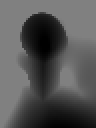

In [9]:
distances = DepthSensors.raycast_depths(field, sensor, camera_transform)
@manipulate for minf = 0:0.1:1.6, maxf = 0.0:0.1:2.6
    distances_bounded = map(d -> min(max(d, minf), maxf)-minf, distances)

    # gotta flip it around a bit
    imagearray = distances_bounded[:,end:-1:1]
    # drawww
    convert(Image, imagearray)
end